In [7]:
# ----------------------------
# 1. Imports & Data Loading
# ----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Load dataset
data = pd.read_csv("../../data/simulation_security_labels_n-1.csv")
data["status_binary"] = data["status"].map({"secure": 1, "insecure": 0})

# Drop unused columns
columns_to_drop = [
    "timestamp", "status", "status_binary",
    "max_line_loading_percent_basecase",
    "min_bus_voltage_pu_basecase",
    "max_bus_voltage_pu_basecase",
    "max_line_loading_percent_contingency",
    "min_bus_voltage_pu_contingency",
    "max_bus_voltage_pu_contingency"
]
X = data.drop(columns=columns_to_drop, axis=1, errors="ignore")
y = data["status_binary"]

In [8]:
# ----------------------------
# 2. Split into Pool and Validation Set
# ----------------------------
X_pool, X_val, y_pool, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [9]:
# ----------------------------
# 3. Active Learning Function
# ----------------------------
def run_active_learning(X_pool, y_pool, X_val, y_val, initial_size=100, batch_size=200, iterations=5, strategy="uncertainty"):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    
    initial_idx = np.random.choice(range(len(X_pool)), size=initial_size, replace=False)
    X_labeled = X_pool.iloc[initial_idx].copy()
    y_labeled = y_pool.iloc[initial_idx].copy()
    X_pool = X_pool.drop(index=X_pool.iloc[initial_idx].index)
    y_pool = y_pool.drop(index=y_pool.iloc[initial_idx].index)
    
    accuracies = []

    for i in range(iterations):
        model.fit(X_labeled, y_labeled)
        y_pred = model.predict(X_val)
        acc = accuracy_score(y_val, y_pred)
        accuracies.append(acc)
        print(f"📈 Iteration {i+1} [{strategy}] - Accuracy: {acc:.4f}")

        if strategy == "uncertainty":
            probs = model.predict_proba(X_pool)
            uncertainty = np.abs(probs[:, 0] - 0.5)
            query_idx = uncertainty.argsort()[:batch_size]
        elif strategy == "random":
            query_idx = np.random.choice(range(len(X_pool)), size=batch_size, replace=False)
        else:
            raise ValueError("Invalid strategy")

        X_labeled = pd.concat([X_labeled, X_pool.iloc[query_idx]])
        y_labeled = pd.concat([y_labeled, y_pool.iloc[query_idx]])
        X_pool = X_pool.drop(index=X_pool.iloc[query_idx].index)
        y_pool = y_pool.drop(index=y_pool.iloc[query_idx].index)

    return accuracies

In [10]:
# ----------------------------
# 4. Run Active Learning & Random Sampling
# ----------------------------
acc_active = run_active_learning(X_pool.copy(), y_pool.copy(), X_val, y_val, strategy="uncertainty")
acc_random = run_active_learning(X_pool.copy(), y_pool.copy(), X_val, y_val, strategy="random")

📈 Iteration 1 [uncertainty] - Accuracy: 0.8404
📈 Iteration 2 [uncertainty] - Accuracy: 0.8928
📈 Iteration 3 [uncertainty] - Accuracy: 0.8860
📈 Iteration 4 [uncertainty] - Accuracy: 0.9179
📈 Iteration 5 [uncertainty] - Accuracy: 0.9327
📈 Iteration 1 [random] - Accuracy: 0.8153
📈 Iteration 2 [random] - Accuracy: 0.8689
📈 Iteration 3 [random] - Accuracy: 0.8689
📈 Iteration 4 [random] - Accuracy: 0.8734
📈 Iteration 5 [random] - Accuracy: 0.8905


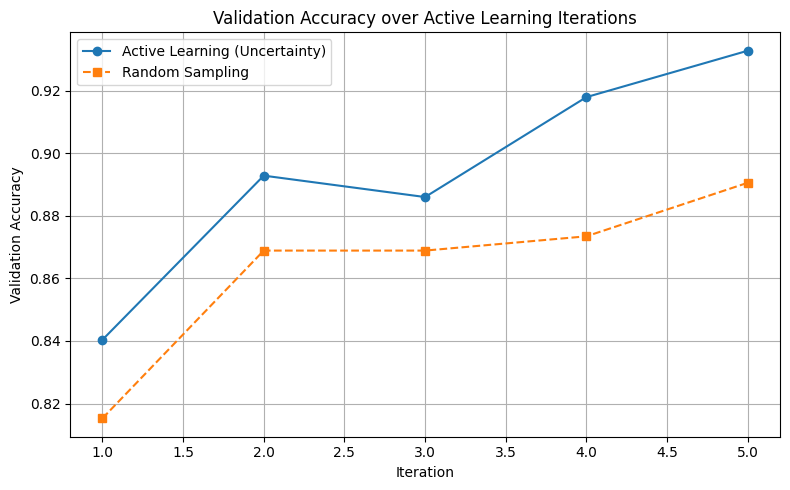

In [11]:
# ----------------------------
# 5. Plot Comparison
# ----------------------------
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(acc_active) + 1), acc_active, marker='o', label="Active Learning (Uncertainty)")
plt.plot(range(1, len(acc_random) + 1), acc_random, marker='s', label="Random Sampling", linestyle="--")
plt.title("Validation Accuracy over Active Learning Iterations")
plt.xlabel("Iteration")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()